<a href="https://colab.research.google.com/github/colaprograms/2019-hackathon-ocr-wymbah/blob/master/notebooks/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook trains a model!

## If you're in a Jupyter notebook:

You have to download the image files yourself with `git clone`.
Once you are done, the directory structure should look like
```
project/
project/AI4Good---Meza-OCR-Challenge
project/AI4Good---Meza-OCR-Challenge/cell_images, etc
project/2019-hackathon-ocr-wymbah
project/2019-hackathon-ocr-wymbah/nets
project/2019-hackathon-ocr-wymbah/notebooks
project/2019-hackathon-ocr-wymbah/util
```

You may need these commands:
```
git clone https://github.com/Charitable-Analytics-International/AI4Good---Meza-OCR-Challenge
git clone https://github.com/colaprograms/2019-hackathon-ocr-wymbah
```

## If you're in Google Colab:

The notebook should automatically download everything. All you have to do is hit "Run all" and then authorize the notebook to mount your drive so that it can save checkpoints in `My Drive/code/checkpoint`.

If you run the notebook for the first time and scroll down, you should see something like
```
We're on Google Colab!
Already up to date.
Now mounting your Google Drive (not mine, yours)
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?(et cetera)

Enter your authorization code:
```

Go to the URL as instructed and enter the authorization code. The notebook will then print

```
Mounted at /content/gdrive
Changing directory to /content/2019-hackathon-ocr-wymbah
Checkpoints are going to /content/gdrive/My Drive/code/checkpoint
```

and then (ideally) the rest of the cells will run and it will start training.

In [22]:
import os, torch, re, sys
import numpy as np
import matplotlib.pyplot as p
import random, PIL

In [23]:
USERNAME = "colaprograms"
REPOSITORY = "torch-template"
GOOGLE_DRIVE_CHECKPOINT_DIR = "code/checkpoint"

import os.path
from os.path import join
def exists(*arg):
    return os.path.exists(join(*arg))
def trymkdir(*arg):
    try:
        os.mkdir(join(*arg))
        print("Created directory", join(*arg))
    except:
        pass

if exists("/content"):
    print("We're on Google Colab!")
    print("We will automatically try to download everything.")
    PATH = "/content"
    os.chdir(PATH)
    # Get the data files here
    #if not exists(PATH, "AI4Good---Meza-OCR-Challenge"):
    #  !git clone https://github.com/Charitable-Analytics-International/AI4Good---Meza-OCR-Challenge
    CODE_PATH = join(PATH, REPOSITORY)
    if not os.path.exists(CODE_PATH):
        !git clone https://github.com/{USERNAME}/{REPOSITORY}
    "The code may have changed on GitHub since we cloned it"
    os.chdir(CODE_PATH)
    !git pull
    
    "Mount Google Drive on /content/gdrive/My Drive and try to save checkpoints in code/checkpoint"
    print("Now mounting your Google Drive (not mine, yours)")
    from google.colab import drive
    drive.mount("/content/gdrive")
    CHECKPOINT_PATH = join("/content/gdrive/My Drive", GOOGLE_DRIVE_CHECKPOINT_DIR)
    os.makedirs(CHECKPOINT_PATH, exists_ok=True)
    trymkdir("/content/gdrive/My Drive/code")
    trymkdir("/content/gdrive/My Drive/code/checkpoint")
    CHECKPOINT_PATH = "/content/gdrive/My Drive/code/checkpoint"
else:
    print("We're in a Jupyter notebook!")
    print("We will NOT automatically get the training files or pull from git.")
    if exists("../notebooks"):
        "Move out of the notebooks directory"
        os.chdir("..")
    CODE_PATH = os.getcwd()
    CHECKPOINT_PATH = join(CODE_PATH, "checkpoint")
    trymkdir(CHECKPOINT_PATH)

print("Changing directory to", CODE_PATH)
os.chdir(CODE_PATH)
print("Checkpoints are going to", CHECKPOINT_PATH)

We're in a Jupyter notebook!
We will NOT automatically get the training files or pull from git.
Changing directory to /home/gibson/sdb2/cola/ass/balls/template
Checkpoints are going to /home/gibson/sdb2/cola/ass/balls/template/checkpoint


In [24]:
import torch.nn as nn
import torch.optim as optim
import torchvision

# Numpy will show all numbers to 4 decimal places
np.set_printoptions(4, suppress=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reloading util.file
Using images in ../AI4Good---Meza-OCR-Challenge

Reloading util.chars

Reloading nets.ctcnet

Loaded 6747 training images and 750 validation images
Showing an example training image

Label: 14
Image mean: [0. 0. 0.]
Image std dev: [0.5 0.5 0.5]


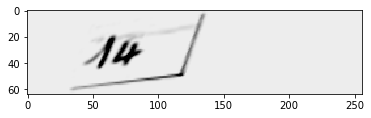

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Showing an example validation image

Label: 10.1
Image mean: [0. 0. 0.]
Image std dev: [0.5 0.5 0.5]


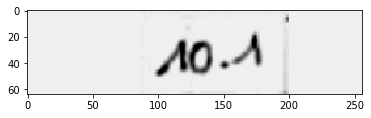

In [25]:
# Reload all of our modules in case they changed

modules_to_reload = [
    "util.file",
    "util.chars",
    "nets.ctcnet"
]

from importlib import import_module, reload
for module in modules_to_reload:
    print("Reloading %s" % module)
    reload(import_module(module))

from util.chars import chars, nchars, idx, input_to_string
from util.file import FileHolder
from nets.ctcnet import CTCModel

fh = FileHolder()
print("Loaded %d training images and %d validation images" %
     (fh.ntraining(), fh.nvalidation()))

def show(z):
    print()
    b = z[0].numpy().squeeze().transpose(1, 2, 0)
    print("Label:", z[1][0])
    print("Image mean:", np.mean(b, axis=(0, 1)))
    print("Image std dev:", np.std(b, axis=(0, 1)))
    p.imshow(b * 0.3 + 0.9)
    p.show()

print("Showing an example training image")
b = fh.get_batch_tensor(1)
show(b)

print()
print("Showing an example validation image")
b = fh.get_batch_tensor(1, validation=True)
show(b)

In [26]:
BATCH_SIZE = 64

class Runner:
    def __init__(self):
        self.model = CTCModel().cuda()
        self.loss = nn.CTCLoss(reduction='sum').cuda()
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr = 0.0001, # It gets pretty unstable with larger lrs.
            momentum = 0.9,
            nesterov = True, # Everyone loves Nesterov
            weight_decay = 0.001 # A little bit of regularization
        )
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            patience=6,
            verbose=True
        )
        self.trainloss = []
        self.validloss = []
        
    def predict(self, inputs):
        # Enter evaluation mode
        self.model.eval()
        return self.model(inputs.clone().cuda())
    
    def one_batch_loss(self, inputs, outputs):
        inputs = self.model(inputs.clone().cuda())
        inputs = inputs.permute(1, 0, 2)
        # sequence, batch, channels
        # All sequences should be 32 long, because that's
        # the size of the image after we pad to 256 pixels
        # and then run it through the convolutions.
        assert inputs.shape[0] == 32
        input_lengths = torch.tensor(
            [32 for i in range(inputs.shape[1])],
            dtype=torch.int32
        )
        target, target_lengths = Runner.maketarget(outputs)
        
        loss = self.loss(inputs, target, input_lengths, target_lengths)
        return loss
    
    @staticmethod
    def maketarget(outputs):
        classes = []
        "Concatenate all the outputs into one array"
        for string in outputs:
            classes.extend([idx[c] for c in string])
        lengths = [len(string) for string in outputs]
        # We use int32 because Torch promises us that we
        # can use special CuDNN code if we meet some
        # requirements, and one of the requirements is
        # that these tensors have type torch.int32.
        return (
            torch.tensor(classes, dtype=torch.int32),
            torch.tensor(lengths, dtype=torch.int32)
        )

    def __train(self, epoch):
        # set training mode just in case it has somehow been unset
        self.model.train()
        running_loss = 0.0
        length = 0
        #print("Example output:")
        import time
        if epoch == 0:
          start = time.time()
        for i in range(100):
          inputs, outputs = fh.get_batch_tensor(BATCH_SIZE)
          self.optimizer.zero_grad()
          loss = self.one_batch_loss(inputs, outputs)
          loss.backward()
          self.optimizer.step()
          running_loss += loss.item()
          length += BATCH_SIZE
          if epoch == 0 and i == 10:
            elapsed = time.time() - start
            print("Each epoch should take about %.1f minutes." % (elapsed*10/60))
            loss = None
        trainingloss = running_loss / length
        print("Epoch %d. Loss: %f" % (epoch, trainingloss))
        self.trainloss.append(trainingloss)
    
    def __valid(self, epoch):
        running_loss = 0.0
        length = 0
        with torch.no_grad():
            for i in range(100):
                inputs, outputs = fh.get_batch_tensor(BATCH_SIZE, validation=True)
                loss = self.one_batch_loss(inputs, outputs)
                running_loss += loss.item()
                length += BATCH_SIZE
        validationloss = running_loss / length
        self.scheduler.step(validationloss)
        print("Validation loss: %f" % validationloss)
        self.validloss.append(validationloss)
        file = join(CHECKPOINT_PATH, "checkpoint-%04d-%.2f" % (epoch, validationloss))
        torch.save({
            'model': self.model.state_dict(),
            'trainloss': self.trainloss,
            'validloss': self.validloss
        }, file)
        print("Saved", file)
    
    def load_from(self, file):
        checkpoint = torch.load(file)
        self.model.load_state_dict(checkpoint['model'])
        self.trainloss, self.validloss = checkpoint['trainloss'], checkpoint['validloss']
        
    def run(self, epochs, resume_checkpoint=None):
        if resume_checkpoint is None:
            print("Training network from scratch")
            print("Once the validation loss stops improving, you should probably stop the model.")
            print("For this model, that seems to take around 50 epochs.")
        else:
            self.load_from(resume_checkpoint)
        for epoch in range(epochs):
            self.__train(epoch)
            self.__valid(epoch)

blade = Runner()
blade.run(100, resume_checkpoint=None)

Training network from scratch
Once the validation loss stops improving, you should probably stop the model.
For this model, that seems to take around 50 epochs.
Each epoch should take about 1.1 minutes.
Epoch 0. Loss: 12.560527
Validation loss: 8.046623
Saved /home/gibson/sdb2/cola/ass/balls/template/checkpoint/checkpoint-0000-8.05
Epoch 1. Loss: 7.708551
Validation loss: 7.087555
Saved /home/gibson/sdb2/cola/ass/balls/template/checkpoint/checkpoint-0001-7.09
Epoch 2. Loss: 6.672482
Validation loss: 6.063177
Saved /home/gibson/sdb2/cola/ass/balls/template/checkpoint/checkpoint-0002-6.06
Epoch 3. Loss: 5.838690
Validation loss: 5.356269
Saved /home/gibson/sdb2/cola/ass/balls/template/checkpoint/checkpoint-0003-5.36
Epoch 4. Loss: 4.993338
Validation loss: 4.398475
Saved /home/gibson/sdb2/cola/ass/balls/template/checkpoint/checkpoint-0004-4.40
Epoch 5. Loss: 3.954670
Validation loss: 3.377239
Saved /home/gibson/sdb2/cola/ass/balls/template/checkpoint/checkpoint-0005-3.38
Epoch 6. Loss: 2

KeyboardInterrupt: 

In [21]:
from notebook.services.config import ConfigManager
ConfigManager().update('notebook', {'CodeCell': {'cm_config': {'autoCloseBrackets': False}}})

{'load_extensions': {'codefolding/main': False,
  'nbextensions_configurator/config_menu/main': True,
  'contrib_nbextensions_help_item/main': True,
  'collapsible_headings/main': True},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False}}}